In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle

import tensorflow as tf
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D

Using TensorFlow backend.


In [2]:
mydict = pickle.load(open("data_hand_pose.pickle",'rb'))

In [3]:
data = mydict["images"]
labels = mydict["joints"]

In [4]:
input_tensor = np.array(data)

In [5]:
input_tensor.shape

(9432, 145, 167, 3)

In [6]:
label_tensor = np.array(labels, dtype="float")

In [7]:
label_tensor = np.reshape(label_tensor,(-1,label_tensor.shape[1]*label_tensor.shape[2]))
label_tensor.shape

(9432, 42)

In [8]:
test_size = 20
train_size = input_tensor.shape[0]-test_size
X_train = input_tensor[:train_size,:,:,:]
X_test = input_tensor[train_size:, :,:,:]
y_train = label_tensor[:train_size,:]
y_test = label_tensor[train_size:,:]

In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((9412, 145, 167, 3), (9412, 42), (20, 145, 167, 3), (20, 42))

In [10]:
gpus = tf.config.experimental.list_physical_devices('GPU') 
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [11]:
model = Sequential()

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=X_train.shape[-3:]))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(128, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(y_train.shape[1]))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 145, 167, 32)      864       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 145, 167, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 145, 167, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 72, 83, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 83, 64)        18432     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 72, 83, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 72, 83, 64)       

In [12]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [14]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
model.fit(X_train, y_train, epochs = 20, batch_size = 128, callbacks = [earlystop_callback], validation_split = 0.2)

Train on 7529 samples, validate on 1883 samples
Epoch 1/20
7529/7529 [==============================] - 28s 4ms/step - loss: 508.4528 - mae: 15.7548 - val_loss: 5789.9142 - val_mae: 66.0415
Epoch 2/20
7529/7529 [==============================] - 25s 3ms/step - loss: 146.6032 - mae: 9.3676 - val_loss: 966.2071 - val_mae: 26.8246
Epoch 3/20
7529/7529 [==============================] - 25s 3ms/step - loss: 123.9506 - mae: 8.6503 - val_loss: 121.3930 - val_mae: 8.2575
Epoch 4/20
7529/7529 [==============================] - 25s 3ms/step - loss: 104.5978 - mae: 7.9178 - val_loss: 148.3634 - val_mae: 9.7178
Epoch 5/20
7529/7529 [==============================] - 25s 3ms/step - loss: 94.4611 - mae: 7.5252 - val_loss: 229.9496 - val_mae: 13.1026
Epoch 6/20
7529/7529 [==============================] - 26s 3ms/step - loss: 81.8014 - mae: 6.9891 - val_loss: 69.8678 - val_mae: 5.7456
Epoch 7/20
7529/7529 [==============================] - 26s 3ms/step - loss: 80.4319 - mae: 6.9426 - val_loss: 140.5

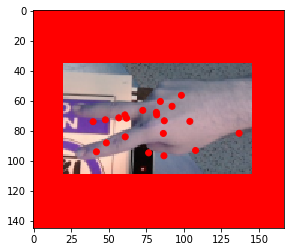

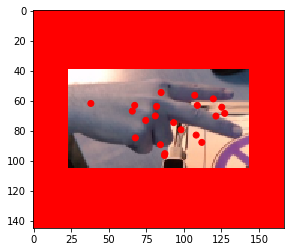

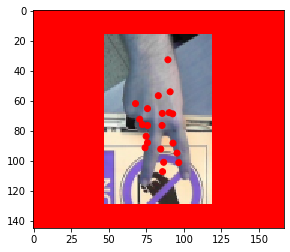

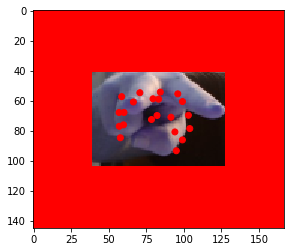

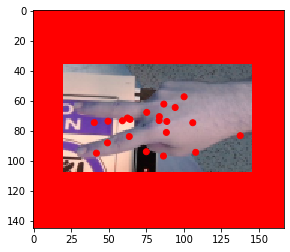

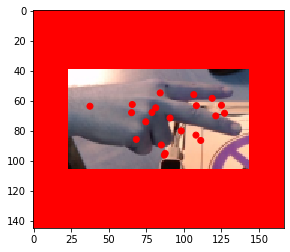

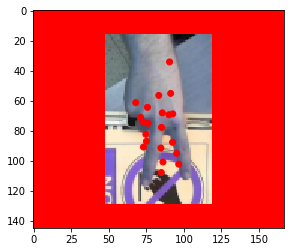

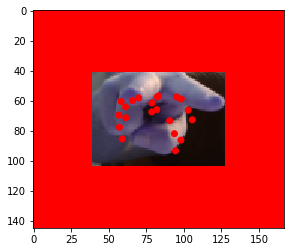

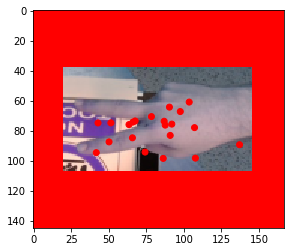

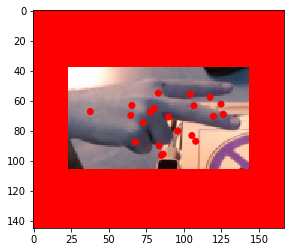

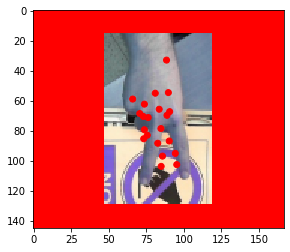

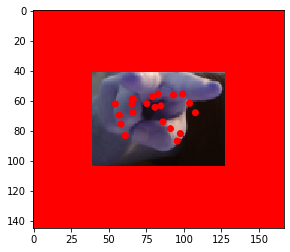

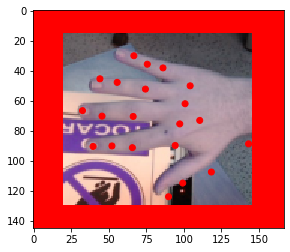

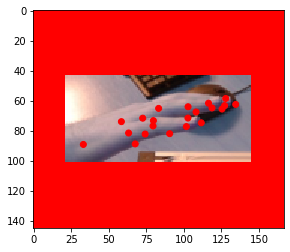

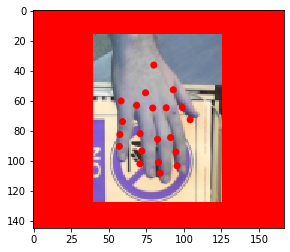

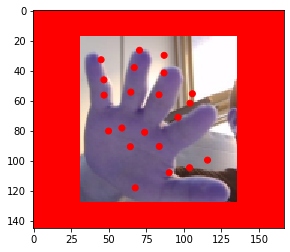

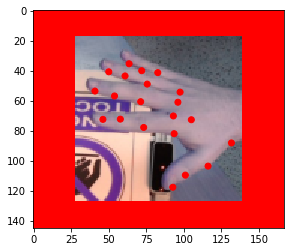

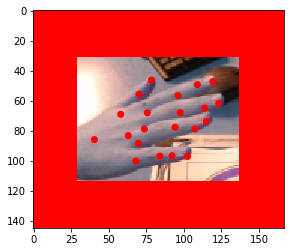

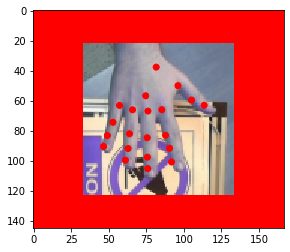

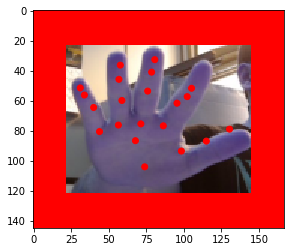

In [16]:
from matplotlib.pyplot import Circle

for i in range(test_size):
    im_test = np.expand_dims(X_test[i,:,:,:], 0)
    preds = model.predict(im_test)


    fig, ax = plt.subplots(1)
    ax.set_aspect('equal')

    ax.imshow(X_test[i,:,:,:])

    for xx, yy in preds.reshape((21,2)):
        circ = Circle((xx,yy),2,color='red')
        ax.add_patch(circ)